**Titanic Spaceship notebook**

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process
from xgboost import XGBClassifier
from xgboost import plot_importance


In [2]:
# load the Data in DataFrames

data_raw = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')
#Create a copy of the training data that will be playing with
data = data_raw.copy(deep=True)
#creating a list to clean both training data and validation data
data_cleaner = [data, data_val]
#check data sample
data.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

**Destination** - The planet the passenger will be debarking to.

**Age** - The age of the passenger.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

**Name** - The first and last names of the passenger.

**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [3]:
#data preview

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
print(data.isna().sum())
print('--'*10)
print(data_val.isna().sum())
print('--'*10)
data.describe(include = 'all')

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
--------------------
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64
--------------------


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [5]:
#Data cleaning --Missing Values 

#inputting most common value for categorical features and median for continuous features
for dataset in data_cleaner:
    dataset['HomePlanet'].fillna(dataset['HomePlanet'].mode()[0],inplace=True)
    dataset['CryoSleep'].fillna(dataset['CryoSleep'].mode()[0], inplace=True)
    dataset['Cabin'].fillna(dataset['Cabin'].mode()[0], inplace=True)
    dataset['Destination'].fillna(dataset['Destination'].mode()[0], inplace=True)
    dataset['Age'].fillna(dataset['Age'].median(), inplace=True)
    dataset['VIP'].fillna(dataset['VIP'].mode()[0], inplace=True)
    dataset['RoomService'].fillna(dataset['RoomService'].median(), inplace=True)
    dataset['FoodCourt'].fillna(dataset['FoodCourt'].median(), inplace=True)
    dataset['ShoppingMall'].fillna(dataset['ShoppingMall'].median(), inplace=True)
    dataset['Spa'].fillna(dataset['Spa'].median(), inplace=True)
    dataset['VRDeck'].fillna(dataset['VRDeck'].median(), inplace=True)
#dropping the name column as it is irrelevant for this process and it is inputtable 
data.drop('Name',  axis=1, inplace=True)
data_val.drop('Name',  axis=1, inplace=True)

In [6]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [7]:
#check if the data is cleaned
print(data.isna().sum())
print('--'*10)
print(data_val.isna().sum())
print('--'*10)
data.describe(include = 'all')

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
--------------------
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64
--------------------


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8693,8693,8693,8693,8693,8693.000000,8693,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,True
freq,1,4803,5656,207,6097,NaN,8494,NaN,NaN,NaN,NaN,NaN,4378
mean,NaN,NaN,NaN,NaN,NaN,28.790291,NaN,220.009318,448.434027,169.572300,304.588865,298.261820,NaN
std,NaN,NaN,NaN,NaN,NaN,14.341404,NaN,660.519050,1595.790627,598.007164,1125.562559,1134.126417,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,41.000000,61.000000,22.000000,53.000000,40.000000,NaN


In [8]:
#Feature Engineering for train and test/validation dataset
#Transform Cabin into the following categorical features: Deck, DeckNumber, Side
for dataset in data_cleaner:
    dataset['Deck'] = dataset['Cabin'].astype(str).str.split('/',expand=True)[0]
    dataset['DeckNumber'] = dataset['Cabin'].astype(str).str.split('/',expand=True)[1]
    dataset['Side'] = dataset['Cabin'].astype(str).str.split('/',expand=True)[2]
#Transform Age, RoomService, FoodCourt, ShoppingMall, Spa, VRdeck into discrete values using Bins method. Given the imbalced data set, the limits were set manually
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),4)
    dataset['RoomServiceBin']=pd.cut(dataset['RoomService'],bins=[-1,500, 4000, 30000])
    dataset['FoodCourtBin']=pd.cut(dataset['FoodCourt'],[-1,500, 4000, 30000])
    dataset['ShoppingMallBin']=pd.cut(dataset['ShoppingMall'],[-1,500, 4000, 30000])
    dataset['SpaBin']=pd.cut(dataset['Spa'],[-1,500, 4000, 30000])
    dataset['VRDeckBin']=pd.cut(dataset['VRDeck'],[-1,500, 4000, 30000])
#A family size feature can be derived from PassengerID and Name features, but given how we don't have missing data in the name column, I will not use it for now

#preview data again
data.info()
data_val.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      8693 non-null   object  
 1   HomePlanet       8693 non-null   object  
 2   CryoSleep        8693 non-null   bool    
 3   Cabin            8693 non-null   object  
 4   Destination      8693 non-null   object  
 5   Age              8693 non-null   float64 
 6   VIP              8693 non-null   bool    
 7   RoomService      8693 non-null   float64 
 8   FoodCourt        8693 non-null   float64 
 9   ShoppingMall     8693 non-null   float64 
 10  Spa              8693 non-null   float64 
 11  VRDeck           8693 non-null   float64 
 12  Transported      8693 non-null   bool    
 13  Deck             8693 non-null   object  
 14  DeckNumber       8693 non-null   object  
 15  Side             8693 non-null   object  
 16  AgeBin           8693 non-null   category


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,Deck,DeckNumber,Side,AgeBin,RoomServiceBin,FoodCourtBin,ShoppingMallBin,SpaBin,VRDeckBin
7655,8168_03,Earth,False,F/1561/S,TRAPPIST-1e,21.0,False,644.0,0.0,0.0,...,False,F,1561,S,"(19.75, 39.5]","(500, 4000]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
7156,7634_01,Earth,True,G/1239/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,True,G,1239,S,"(19.75, 39.5]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
6237,6598_01,Mars,True,F/1263/S,TRAPPIST-1e,35.0,False,0.0,0.0,0.0,...,True,F,1263,S,"(19.75, 39.5]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
3697,3971_01,Earth,False,G/651/P,TRAPPIST-1e,44.0,False,39.0,821.0,0.0,...,False,G,651,P,"(39.5, 59.25]","(-1, 500]","(500, 4000]","(-1, 500]","(-1, 500]","(-1, 500]"
179,0201_02,Europa,True,B/3/S,TRAPPIST-1e,47.0,False,0.0,0.0,0.0,...,True,B,3,S,"(39.5, 59.25]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
5571,5931_01,Europa,False,A/56/P,55 Cancri e,39.0,False,0.0,0.0,0.0,...,False,A,56,P,"(19.75, 39.5]","(-1, 500]","(-1, 500]","(-1, 500]","(500, 4000]","(-1, 500]"
2938,3188_01,Mars,True,E/209/S,55 Cancri e,31.0,False,0.0,0.0,0.0,...,False,E,209,S,"(19.75, 39.5]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
933,0994_02,Earth,False,F/185/S,TRAPPIST-1e,26.0,False,621.0,1.0,98.0,...,False,F,185,S,"(19.75, 39.5]","(500, 4000]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
263,0289_01,Europa,True,C/12/S,55 Cancri e,19.0,False,0.0,0.0,0.0,...,True,C,12,S,"(-0.079, 19.75]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"
1531,1624_03,Earth,False,G/250/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,...,True,G,250,S,"(-0.079, 19.75]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]","(-1, 500]"


<Axes: xlabel='VRDeckBin', ylabel='count'>

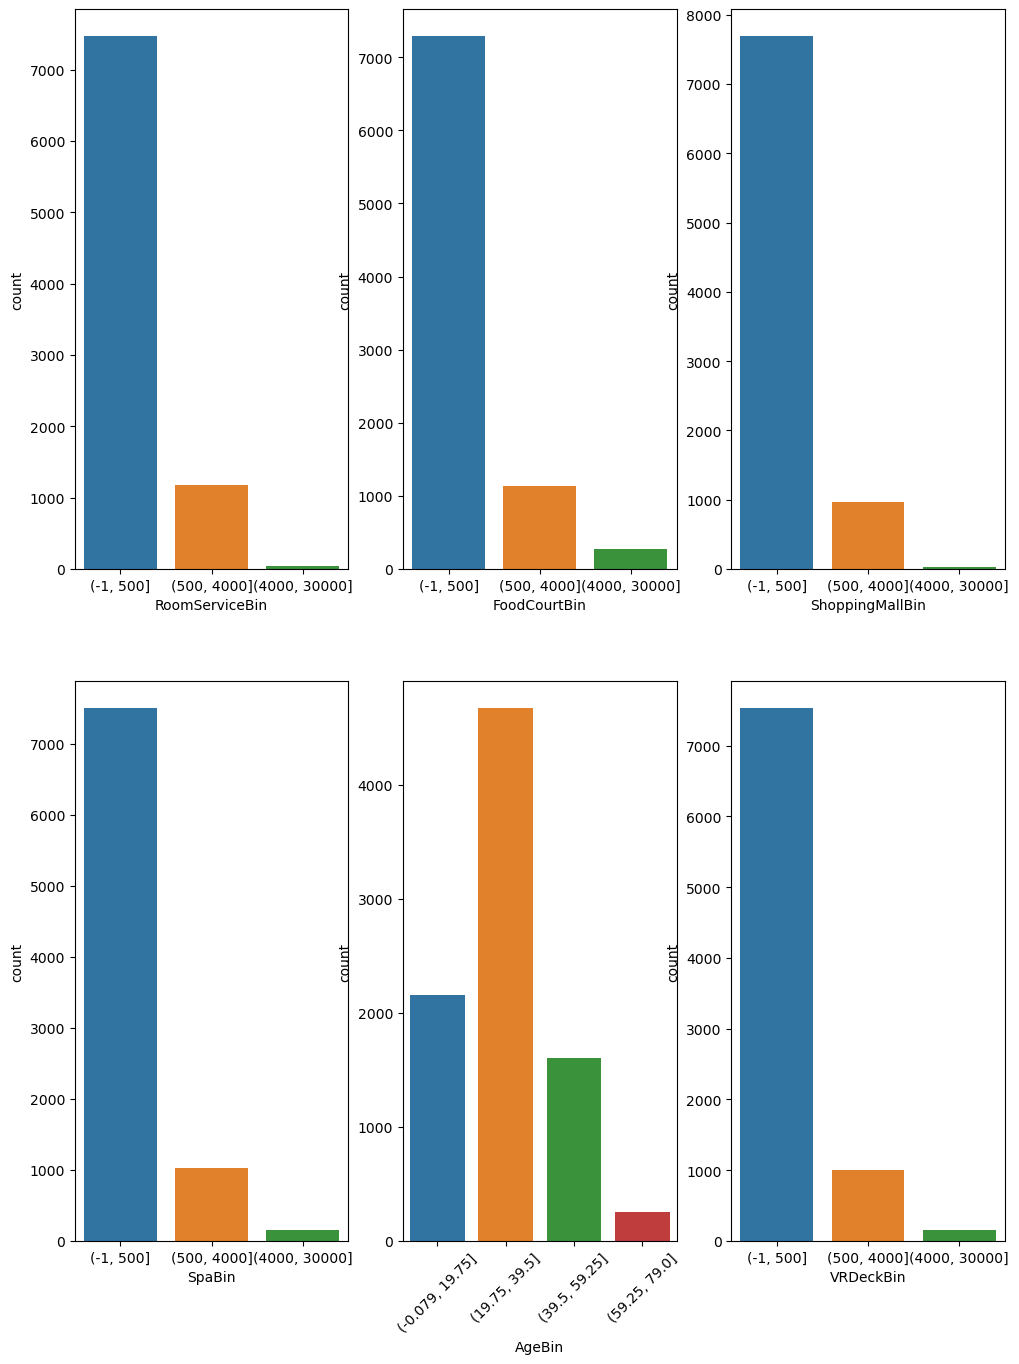

In [9]:
plt.figure(figsize=(12,16))
plt.subplot(231)
sns.countplot(data=data, x='RoomServiceBin')
plt.subplot(232)
sns.countplot(data=data, x='FoodCourtBin')
plt.subplot(233)
sns.countplot(data=data, x='ShoppingMallBin')
plt.subplot(234)
sns.countplot(data=data, x='SpaBin')
plt.subplot(235)
sns.countplot(data=data, x='AgeBin')
plt.tick_params(axis='x', rotation=45)
plt.subplot(236)
sns.countplot(data=data, x='VRDeckBin')


In [10]:
#Convert
#get Dummy Variables for the following features: HomePlanet, CryoSleep,	Cabin(Deck, Side), Destination, VIP
label = LabelEncoder()

for dataset in data_cleaner: 
    dataset['HomePlanet_Code'] = label.fit_transform(dataset['HomePlanet'])
    dataset['CryoSleep_Code'] = label.fit_transform(dataset['CryoSleep'])
    dataset['VIP_Code'] = label.fit_transform(dataset['VIP'])
    dataset['Destination_Code'] = label.fit_transform(dataset['Destination'])
    dataset['Deck_Code'] = label.fit_transform(dataset['Deck'])
    dataset['DeckNumber_Code'] = label.fit_transform(dataset['DeckNumber'])
    dataset['Side_Code'] = label.fit_transform(dataset['Side'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FoodCourtBin'] = label.fit_transform(dataset['FoodCourtBin'])
    dataset['RoomServiceBin_Code'] = label.fit_transform(dataset['RoomServiceBin'])
    dataset['ShoppingMallBin_Code'] = label.fit_transform(dataset['ShoppingMallBin'])
    dataset['SpaBin_Code'] = label.fit_transform(dataset['SpaBin'])
    dataset['VRDeckBin_Code'] = label.fit_transform(dataset['VRDeckBin'])




  


In [11]:
data['Transported'] = label.fit_transform(data['Transported'])


In [12]:
#define y variable aka target/outcome
Target=['Transported'] 

Features = ['HomePlanet_Code', 'CryoSleep_Code', 'VIP_Code', 'Destination_Code','Deck_Code', 'DeckNumber_Code', 'Side_Code', 'AgeBin_Code', 'FoodCourtBin', 'RoomServiceBin_Code',
          'ShoppingMallBin_Code', 'SpaBin_Code', 'VRDeckBin_Code']
data_Xy = data[Target] +data[Features] 

In [13]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VIP_Code,Destination_Code,Deck_Code,DeckNumber_Code,Side_Code,AgeBin_Code,RoomServiceBin_Code,ShoppingMallBin_Code,SpaBin_Code,VRDeckBin_Code
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0,2,1,0,0,1,0,0,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0,2,5,0,1,1,0,0,1,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,1,2,0,0,1,2,0,0,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,0,2,0,0,1,1,0,0,1,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,0,2,5,1,1,0,0,0,1,0


In [14]:
data_val.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VIP_Code,Destination_Code,Deck_Code,DeckNumber_Code,Side_Code,AgeBin_Code,RoomServiceBin_Code,ShoppingMallBin_Code,SpaBin_Code,VRDeckBin_Code
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,0,2,6,820,1,1,0,0,0,0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,...,0,2,5,927,1,0,0,0,1,0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,...,0,0,2,0,1,1,0,0,0,0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,...,0,2,2,1,1,1,0,0,0,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,...,0,2,5,1029,1,1,0,1,0,0


In [15]:
#check if the data is cleaned
print(data.isna().sum())
print('--'*10)
print(data_val.isna().sum())
print('--'*10)
data.describe(include = 'all')

PassengerId             0
HomePlanet              0
CryoSleep               0
Cabin                   0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Transported             0
Deck                    0
DeckNumber              0
Side                    0
AgeBin                  0
RoomServiceBin          0
FoodCourtBin            0
ShoppingMallBin         0
SpaBin                  0
VRDeckBin               0
HomePlanet_Code         0
CryoSleep_Code          0
VIP_Code                0
Destination_Code        0
Deck_Code               0
DeckNumber_Code         0
Side_Code               0
AgeBin_Code             0
RoomServiceBin_Code     0
ShoppingMallBin_Code    0
SpaBin_Code             0
VRDeckBin_Code          0
dtype: int64
--------------------
PassengerId             0
HomePlanet              0
CryoSleep               0
Cabi

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VIP_Code,Destination_Code,Deck_Code,DeckNumber_Code,Side_Code,AgeBin_Code,RoomServiceBin_Code,ShoppingMallBin_Code,SpaBin_Code,VRDeckBin_Code
count,8693,8693,8693,8693,8693,8693.000000,8693,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,4803,5656,207,6097,NaN,8494,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,28.790291,NaN,220.009318,448.434027,169.572300,...,0.022892,1.494306,4.344185,960.321063,0.516162,0.994823,0.144714,0.118141,0.154722,0.150236
std,NaN,NaN,NaN,NaN,NaN,14.341404,NaN,660.519050,1595.790627,598.007164,...,0.149568,0.814966,1.775938,506.054595,0.499767,0.741478,0.364993,0.333315,0.408281,0.402448
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,1.000000,3.000000,523.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,2.000000,5.000000,1009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,41.000000,61.000000,22.000000,...,0.000000,2.000000,6.000000,1363.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000


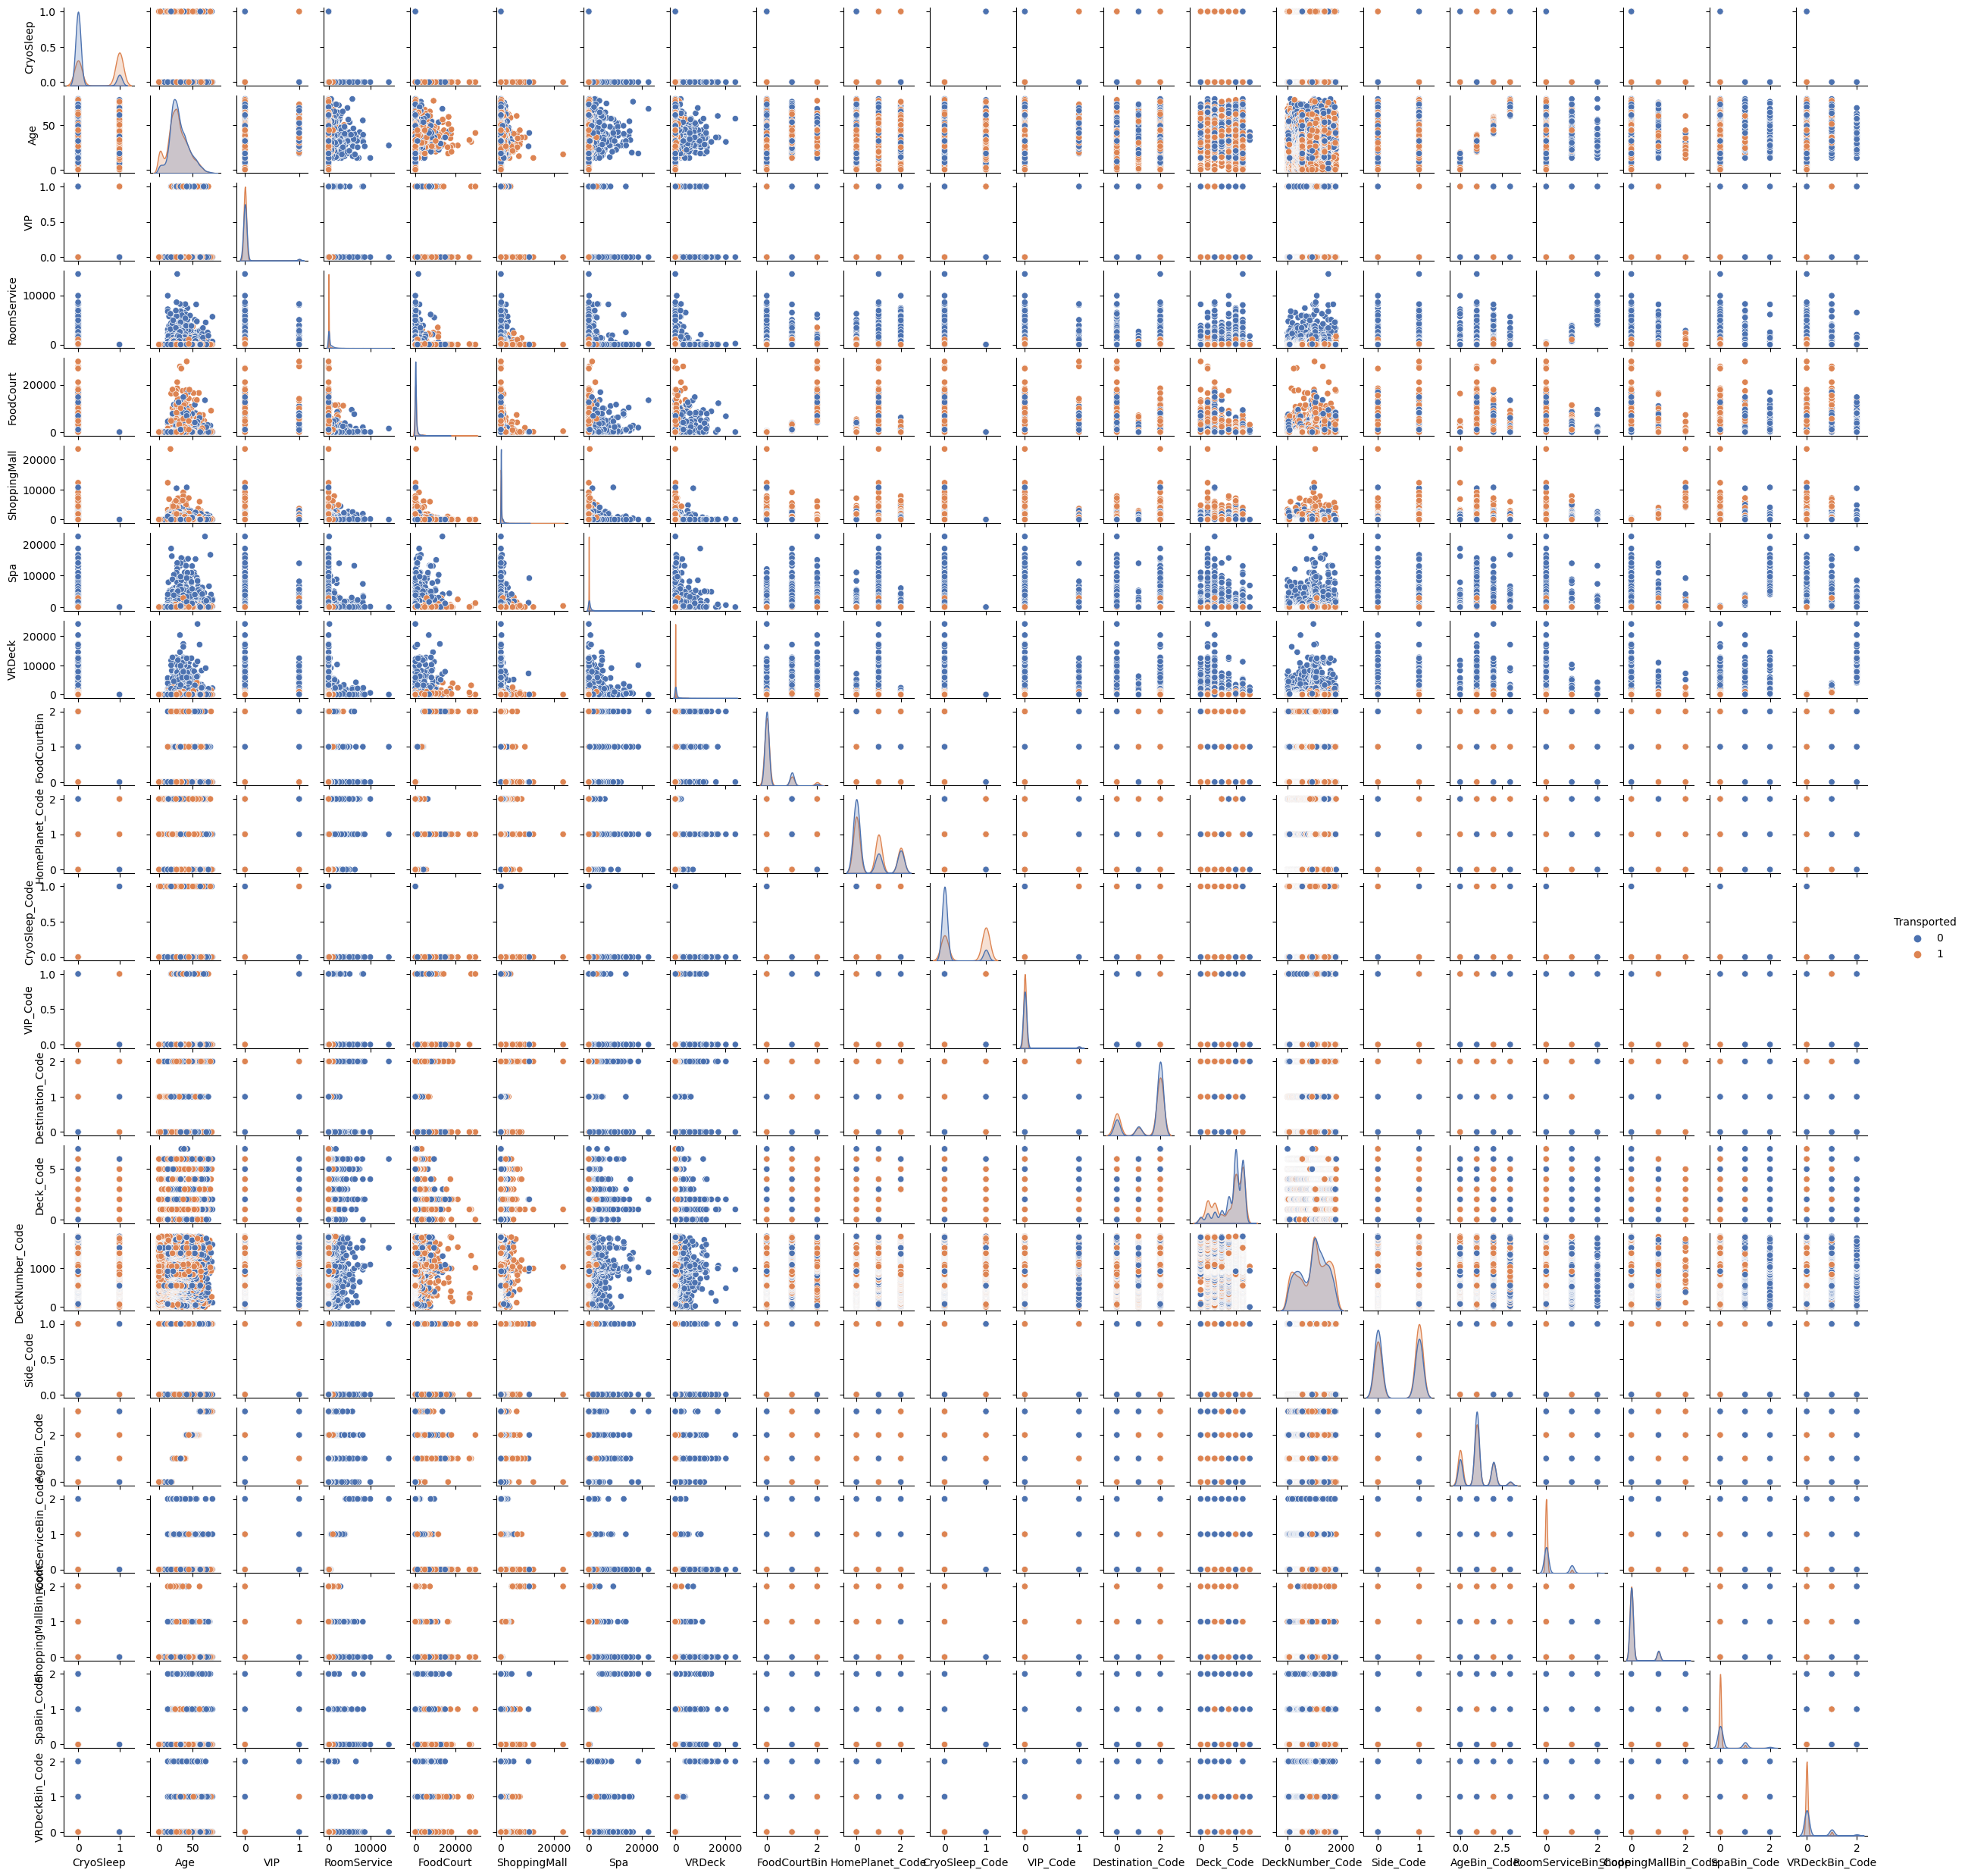

In [16]:
#Data Exploration 

sns.pairplot(data=data, hue='Transported', palette = 'deep', height=1.2, diag_kind = 'kde')


In [17]:
Xy_columns = Target + Features 
Xy_columns

['Transported',
 'HomePlanet_Code',
 'CryoSleep_Code',
 'VIP_Code',
 'Destination_Code',
 'Deck_Code',
 'DeckNumber_Code',
 'Side_Code',
 'AgeBin_Code',
 'FoodCourtBin',
 'RoomServiceBin_Code',
 'ShoppingMallBin_Code',
 'SpaBin_Code',
 'VRDeckBin_Code']

In [18]:
data1= data[Xy_columns]

<Axes: >

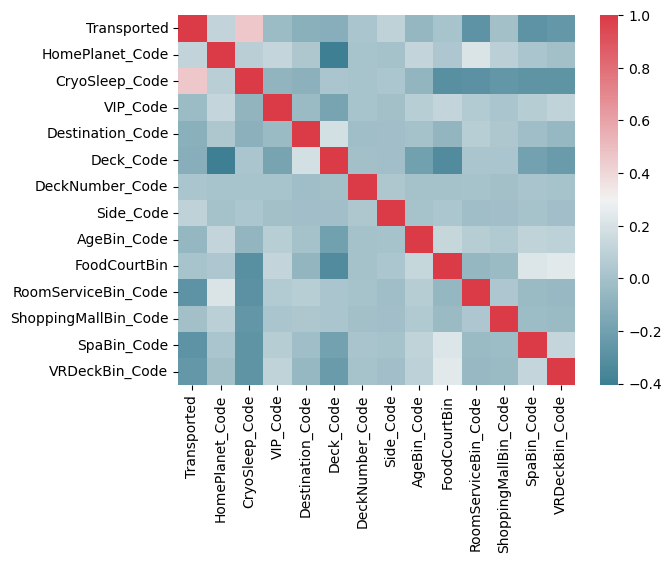

In [19]:
sns.heatmap(data1.corr(), cmap=sns.diverging_palette(220, 10, as_cmap = True))

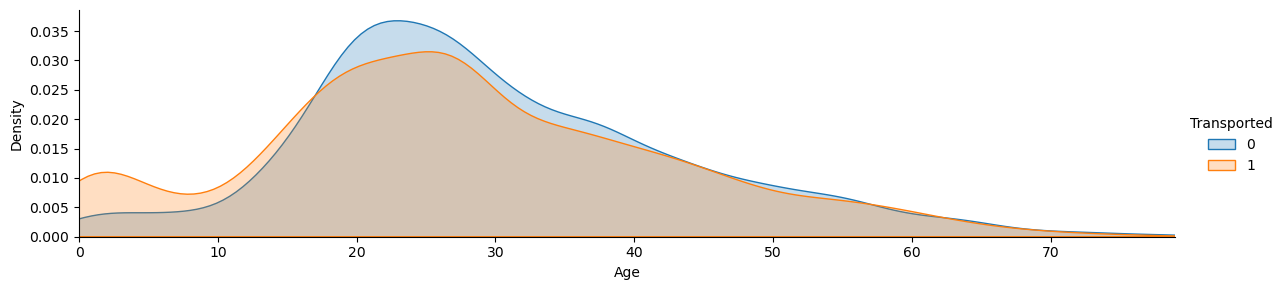

In [20]:
a =sns.FacetGrid(data=data, hue = 'Transported', aspect=4)
a.map(sns.kdeplot,'Age', fill= True )
a.set(xlim= (0,  data['Age'].max()))
a.add_legend()

In [21]:
#Machine Learning Algorithm (MLA) Selection and Initialization

#Ensemble Methods
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),


    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    XGBClassifier()    
    ]

In [22]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state=0) 



In [23]:

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


MLA_predict = data[Target]

row_index =0

for alg in MLA:
     #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())


    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data[Features], data[Target], cv  = cv_split, return_train_score=True)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
     #save MLA predictions - see section 6 for usage
    alg.fit(data[Features], data[Target].values.ravel())
    MLA_predict[MLA_name] = alg.predict(data[Features])
    
    row_index+=1

#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict



,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
2,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.803586,0.787232,0.260911
10,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.900153,0.779525,0.189656
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': 'de...",0.7786,0.775882,0.082514
5,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.77164,0.770169,0.814055
3,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.99302,0.758129,0.244418
1,BaggingClassifier,"{'base_estimator': 'deprecated', 'bootstrap': ...",0.972924,0.754946,0.056085
6,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.755858,0.754678,0.002386
7,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.736989,0.739379,0.001647
4,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.990431,0.61273,10.1936
8,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.739444,0.587883,0.002148


Text(0, 0.5, 'Algorithm')

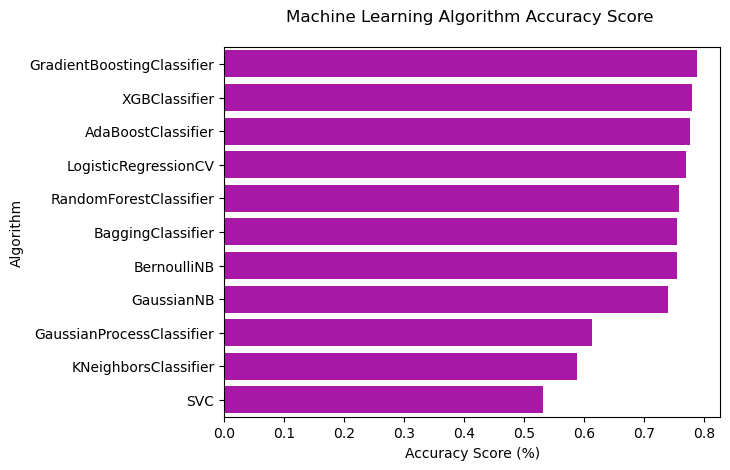

In [24]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [25]:
MLA_compare[MLA_compare['MLA Name']=='XGBClassifier']

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Time
10,XGBClassifier,"{'objective': 'binary:logistic', 'use_label_en...",0.900153,0.779525,0.189656


In [26]:
pd.set_option('display.max_colwidth', None)

<Axes: >

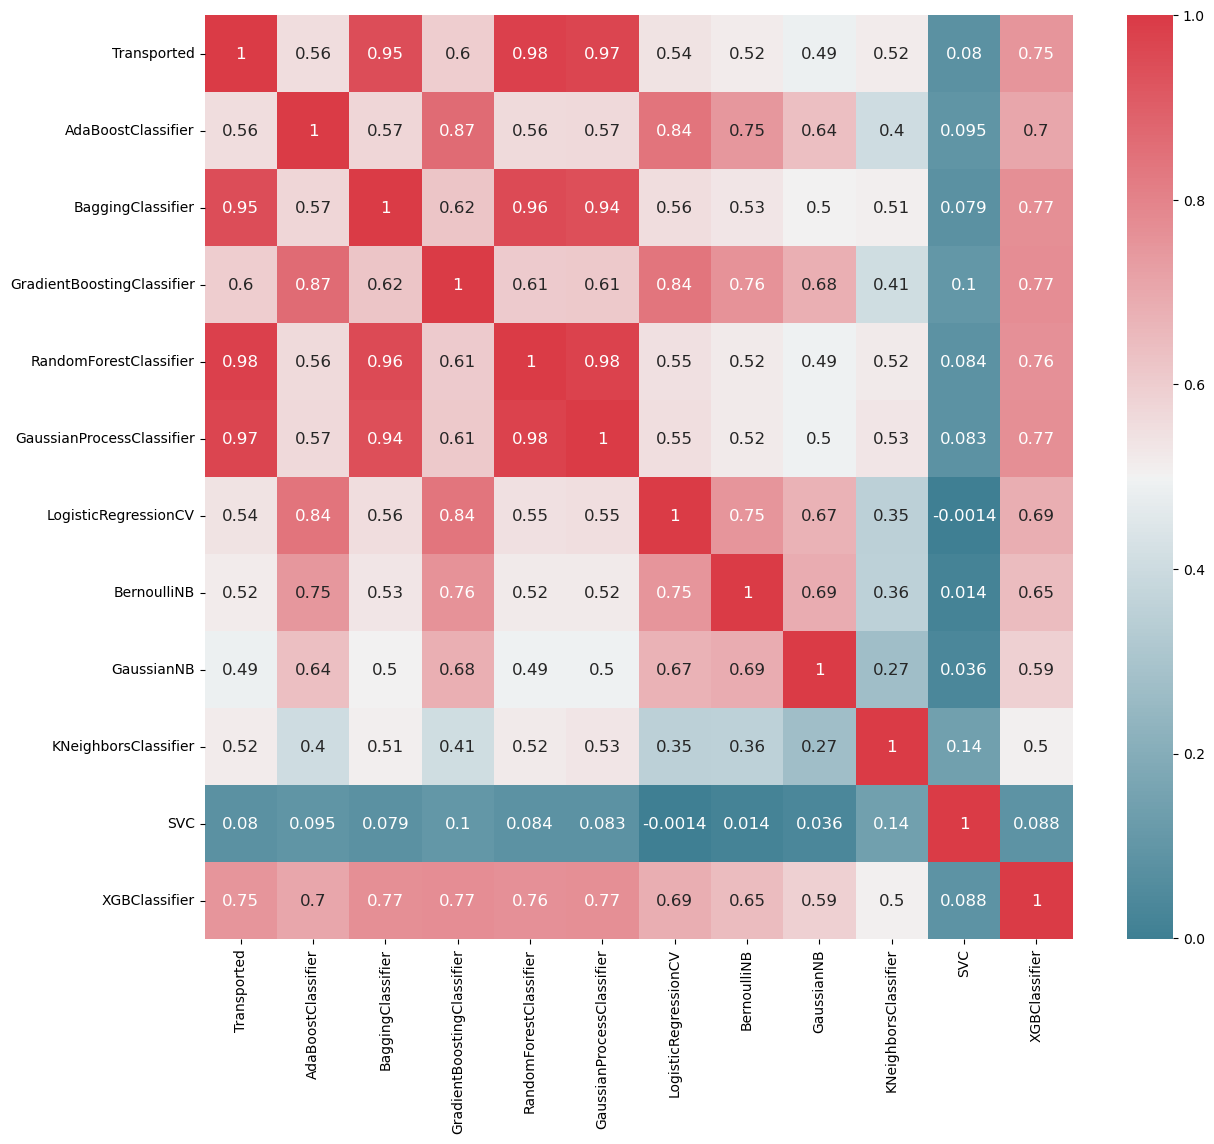

In [27]:
plt.figure(figsize =(14, 12))
sns.heatmap(MLA_predict.corr(), cmap=sns.diverging_palette(220, 10, as_cmap = True),annot=True,annot_kws={'fontsize':12 })

In [28]:
#XGboostmodel

XGBMLA =  XGBClassifier(learning_rate=0.02, n_estimators=600
                    )   

base_results = model_selection.cross_validate(XGBMLA, data[Features], data[Target], cv  = cv_split, return_train_score=True)
XGBMLA.fit(data[Features], data[Target])

print('Before XGBMLA parameters', XGBMLA.get_params())
print("BEFORE XGBMLA Training score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE XGBMLA Test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print('-'*10)


#hyper parameeters

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }


Before XGBMLA parameters {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 600, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
BEFORE XGBMLA Training score mean: 85.38
BEFORE XGBMLA

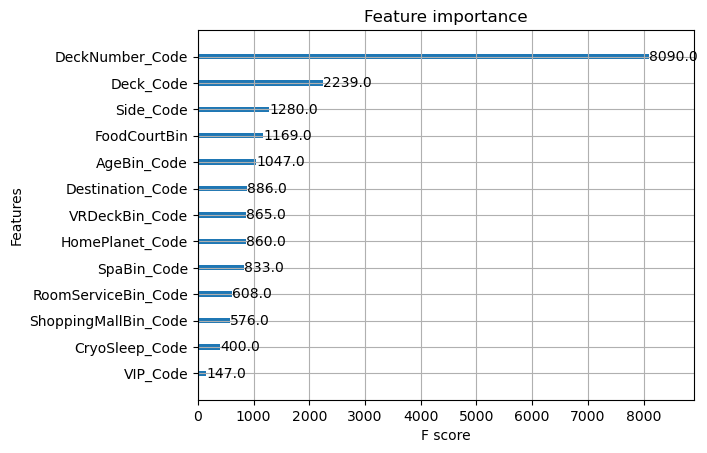

In [29]:
plot_importance(XGBMLA)
plt.show()

In [30]:
# searching for best parameters

tune_model = model_selection.GridSearchCV(XGBClassifier(learning_rate=0.02, n_estimators=600
                    ) ,  param_grid=params, scoring = 'roc_auc', cv = cv_split, return_train_score=True)
tune_model.fit(data[Features], data[Target])

print('After tune_model parameters', tune_model.best_params_)
print("AFTER tune_model Training score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER tune_model Test score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('-'*10)

After tune_model parameters {'colsample_bytree': 0.8, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8}
AFTER tune_model Training score mean: 91.80
AFTER tune_model Test score mean: 88.39
----------


In [40]:
cv_split2 = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .7, random_state=0) 


In [41]:
xgbValidation = XGBClassifier(learning_rate=0.02, n_estimators=600, colsample_bytree = 0.8, gamma = 2, max_depth = 5, min_child_weight = 1, subsample = 0.8)

In [42]:
results =  model_selection.cross_validate(xgbValidation, data[Features], data[Target], cv  = cv_split2, return_train_score=True)
xgbValidation.fit(data[Features], data[Target])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [43]:
print('xgbVal parameters', xgbValidation.get_params())
print("xgbVal Training score mean: {:.2f}". format(results['train_score'].mean()*100)) 
print("xgbVal Test score mean: {:.2f}". format(results['test_score'].mean()*100))
print('-'*10)

xgbVal parameters {'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 2, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 600, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
xgbVal Training score mean: 82.89
xgbVal Test score mean: 78.82
--------

In [45]:
data_val['Transported2'] = xgbValidation.predict(data_val[Features])

In [57]:
data_val['Transported_Bool'] = data_val['Transported2'].astype(bool) 

In [61]:
data_val.rename(columns={'Transported_Bool': 'Transported'}, inplace=True)

In [64]:
submit = data_val[['PassengerId','Transported']]
submit.to_csv("submit.csv", index=False)

print('Validation Data Distribution: \n', data_val['Transported'].value_counts(normalize = True))
submit.sample(10)

Validation Data Distribution: 
 False    0.522095
True     0.477905
Name: Transported, dtype: float64


,PassengerId,Transported
575,1194_01,False
2372,5153_01,True
1775,3780_01,True
282,0622_01,False
286,0625_03,True
2497,5442_01,False
2907,6389_01,False
2511,5493_01,True
3998,8711_01,True
1839,3906_01,False
